# ETL_EDA
This file records the process of acquiring raw data, traforming them, and loading them into a MongoDB. The data are store (almost) in their raw form.

## 1. Raw Data from NY Times 
The [dataset](https://github.com/nytimes/covid-19-data) is a continuously updated (daily) txt file in csv format. It contains the covid-19 cases and deaths in US states and counties (historical data that has the final counts at the end of each day)

In [4]:
import requests
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pymongo


urls = {'counties': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
        'states': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
        'us': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'}

filters = {'us': ['date'],
           'states': ['date', 'state'],
           'counties': ['date', 'state', 'county']}

## 2. Raw Data to Documents/Dicts
Using pandas, it is simple to parse a in-memory string. The first few lines of description need to be skipped. Datetime conversion is made and blank lines are dropped. Now the data can be easily converted to a list of dicts which is what we want for the MongoDB.

In [11]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [7]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [9]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [53]:
states = list(df['state'].unique())

## 3. Upsert MongoDB
If we fetch the data frequently, there are lots of duplicate data entry between each run. The de-duplication happens at insertion. The MongoDB API to use is `collection.replace_one(filter=..., replacement=..., upsert=True)`. The statement matches a document in MongoDB with `filter`, replaces it with `replacement` if the document exists or inserts `replacement` into the database if `filter` matches nothing. 

In [13]:
# from data_acquire import data_fetch
def data_fetch(geo):
    client = pymongo.MongoClient()
    
    # get url
    url = urls[geo]
    
    # raw data from nyt
    req = requests.get(url, timeout=1)
    req.raise_for_status()
    text = req.text

    # raw data to df
    df = pd.read_csv(StringIO(text), delimiter=',')
    df.columns = df.columns.str.strip()             # remove space in columns name
    df['date'] = pd.to_datetime(df['date'])
    df.dropna(inplace=True)  
    df.head()

    # upsert mangodb
    db = client.get_database(geo)   
    collection = db.get_collection(geo) 

    update_count = 0
    for record in df.to_dict('records'):
        result = collection.replace_one(
            filter={_:record[_] for _ in filters[geo]},    # locate the document if exists
            replacement=record,                         # latest document
            upsert=True)                                # update if exists, insert if not
        if result.matched_count > 0:
            update_count += 1
    print(f'{geo}:', 
          f'rows={df.shape[0]}, update={update_count}, '
          f'insert={df.shape[0]-update_count}')

In [16]:
# %%time
# for geo in list(urls.keys()):
#     data_fetch(geo)

data_fetch('us')

us: rows=687, update=0, insert=687


In [12]:
# # db = client.get_database(geo)   
# # collection = db.get_collection(geo) 

# update_count = 0
# for record in df.to_dict('us'):
#     print(record)
#     result = collection.replace_one(
#         filter={_:record[_] for _ in filters[geo]},    # locate the document if exists
#         replacement=record,                         # latest document
#         upsert=True)                                # update if exists, insert if not
#     if result.matched_count > 0:
#         update_count += 1
# print(f"rows={df.shape[0]}, update={update_count}, "
#       f"insert={df.shape[0]-update_count}")

ValueError: orient 'us' not understood

Use the smallest datset -- 'us' for EDA.

In [17]:
client = pymongo.MongoClient()
db = client.get_database("us")
collection = db.get_collection("us")
data = list(collection.find())

In [20]:
df = pd.DataFrame.from_records(data)    
df.drop('_id', axis=1, inplace=True)


In [21]:
df

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
682,2021-12-03,48952109,786313
683,2021-12-04,49010250,786803
684,2021-12-05,49044822,786964
685,2021-12-06,49242271,788315


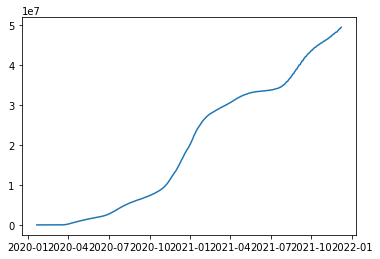

In [24]:
plt.plot(df.date.values, df.cases.values, label='Cases over time')
plt.plot(df.date.values, df.deaths.values, label='Deaths over time')

plt.show()

In [27]:
plot(df.date.values, df.deaths.values, label='Deaths over time')


NameError: name 'plot' is not defined